# Random Forest
Laden des auf IDS18 trainierten Modells  
Test auf IDS17

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS17

In [3]:
# IDS17 Datensatz einlesen
ids17 = pd.read_parquet(os.path.join(parquet_verzeichnis_ids17 + '_prep_0'))
logging.info("Class distribution\n{}".format(ids17.Label.value_counts()))

2024-11-04 16:03:57 - INFO - Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Web Attack - Brute Force             73
Web Attack - XSS                     18
Web Attack - SQL                     13
Name: count, dtype: int64


In [4]:
print(ids17.shape)
print(ids17.columns)

(1923167, 84)
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Vari

### Trennen von Features und Labels

In [5]:
X = ids17.iloc[:, :-1]  # Alle Spalten außer der letzten
print(f"Form von X: {X.shape}")
y = ids17.iloc[:, -1]   # Die letzte Spalte
print(f"Form von y: {y.shape}")

Form von X: (1923167, 83)
Form von y: (1923167,)


### Label Encoding für y

In [6]:
label_encoder = joblib.load('label_encoder.pkl')
y_encoded = label_encoder.fit_transform(y)

print(f"Einzigartige Labels: {label_encoder.classes_}")
print(f"Kodierte Labels: {np.unique(y_encoded)}")

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [7]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.fit_transform(X)
print(f"Form von X: {X.shape}")
print(f"Form von X_scaled: {X_scaled.shape}")

Form von X: (1923167, 83)
Form von X_scaled: (1923167, 83)


In [8]:
X_test, y_test = X_scaled, y_encoded
X_test.shape, y_test.shape

((1923167, 83), (1923167,))

### Überprüfen der Klassenverteilung

In [9]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 1582561 Beispiele (82.29%)
  Klasse 1: 736 Beispiele (0.04%)
  Klasse 2: 95144 Beispiele (4.95%)
  Klasse 3: 7567 Beispiele (0.39%)
  Klasse 4: 158468 Beispiele (8.24%)
  Klasse 5: 3859 Beispiele (0.20%)
  Klasse 6: 71767 Beispiele (3.73%)
  Klasse 7: 2961 Beispiele (0.15%)
  Klasse 8: 73 Beispiele (0.00%)
  Klasse 9: 13 Beispiele (0.00%)
  Klasse 10: 18 Beispiele (0.00%)



### Laden des Modells

In [10]:
model = joblib.load('random_forest_model.pkl')

### Evaluierung des Modells auf dem Testdatensatz

In [11]:
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
logging.info(f"Test-Accuracy: {test_accuracy * 100:.2f}%")
logging.info("\nTest Classification Report:\n" + test_report)

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-04 16:04:12

### Klassifikationsbericht und eine Konfusionsmatrix

In [12]:
# Klassifikationsbericht
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_test_pred)
print("Konfusionsmatrix:")
print(cm)

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       0.82      1.00      0.90   1582561
                 Botnet Ares       0.00      0.00      0.00       736
              DDoS-LOIC-HTTP       0.00      0.00      0.00     95144
               DoS GoldenEye       0.00      0.00      0.00      7567
                    DoS Hulk       0.00      0.00      0.00    158468
               DoS Slowloris       0.00      0.00      0.00      3859
Infiltration - NMAP Portscan       0.00      0.00      0.00     71767
              SSH-BruteForce       0.00      0.00      0.00      2961
    Web Attack - Brute Force       0.00      0.00      0.00        73
            Web Attack - SQL       0.00      0.00      0.00        13
            Web Attack - XSS       0.00      0.00      0.00        18

                    accuracy                           0.82   1923167
                   macro avg       0.07      0.09      0.08   1923167
                we

Visualisierung der Konfusionsmatrix

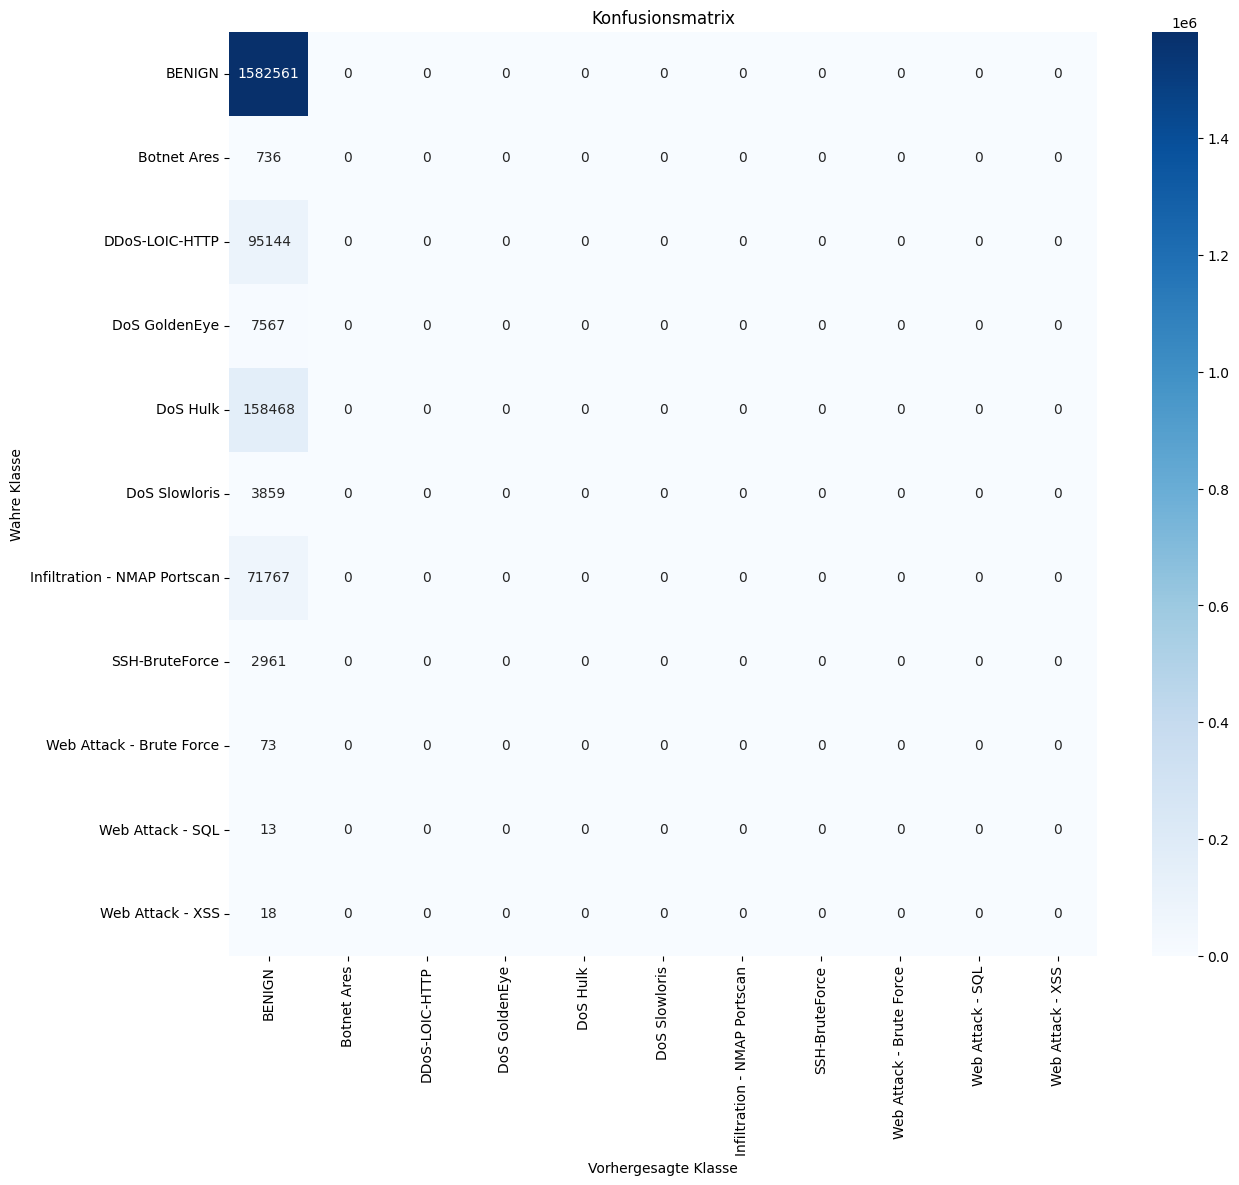

In [13]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
